In [1]:
from tensorflow.keras.models import Model

In [2]:
from tensorflow.keras.layers import Dense, Activation, Input, Conv2DTranspose, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


In [3]:
img_dims = 28
img_chn1 = 1
ltnt_dim=100
(x_train,y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = np.expand_dims(x_train,axis=3)
x_test = np.expand_dims(x_test,axis=3)

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
# we will build the generator convolutional neural network
inpt_noise = Input(shape=(ltnt_dim))
g11 = Dense(7*7*256, activation='relu')(inpt_noise)
g12 = BatchNormalization()(g11)
g13 = Reshape((7,7,256))(g12)
g14= Conv2DTranspose(128, (5,5), strides=(1,1),padding='same', activation='relu')(g13)
g15 = BatchNormalization()(g14)
g16= Conv2DTranspose(64, (5,5), strides=(2,2),padding='same', activation='relu')(g15)
g17 = BatchNormalization()(g16)
g18= Conv2DTranspose(1, (5,5), strides=(2,2),padding='same', activation='sigmoid')(g17)
generator = Model(inpt_noise, g18)
gnrtr_img = generator(inpt_noise)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864

In [5]:
#build the critic convolutional network
inpt_img = Input(shape=(img_dims,img_dims, img_chn1 ))
d11 = Conv2D(64,(5,5), strides=(2,2), padding='same', activation='relu')(inpt_img)
d12= Dropout(0.3)(d11)

d13 = Conv2D(128,(5,5), strides=(2,2), padding='same', activation='relu')(d12)
d14= Dropout(0.3)(d13)

d15 = Flatten()(d14)
d16= Dense(1,activation='sigmoid')(d15)
critic = Model(inpt_img, d16)
validity = critic(gnrtr_img)
critic.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273

In [6]:
optimizer = Adam(0.0002, 0.5)

critic.compile(loss='binary_crossentropy', optimizer=optimizer, 
               metrics=['accuracy'])

critic.trainable = False

gen_crt = Model(inpt_noise, validity)
gen_crt.compile(loss='binary_crossentropy', optimizer=optimizer)

epochs = 12001
batch_size=64
sample_interval=400

In [7]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

samp_imgs = {}
closs = []
gloss = []
cacc = []
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  noise = np.random.uniform(0, 1, (batch_size, ltnt_dim))
  gen_imgs = generator.predict(noise)
  c_loss_real = critic.train_on_batch(imgs, valid)
  c_loss_fake = critic.train_on_batch(gen_imgs, fake)
  c_loss = 0.5 * np.add(c_loss_real, c_loss_fake)

  noise = np.random.uniform(0, 1, (batch_size, ltnt_dim))
  g_loss = gen_crt.train_on_batch(noise, valid)
  
  closs.append(c_loss[0])
  cacc.append(c_loss[1])
  gloss.append(g_loss)

  if epoch % sample_interval == 0:
    print ("%d [C loss: %f, acc.: %.2f%%] [G loss: %f]" % 
           (epoch, c_loss[0], 100*c_loss[1], g_loss))
  
    noise = np.random.uniform(0, 1, (2, ltnt_dim))
    gen_imgs = generator.predict(noise)
    samp_imgs[epoch] = gen_imgs 

0 [C loss: 0.718357, acc.: 27.34%] [G loss: 0.674142]
400 [C loss: 0.000455, acc.: 100.00%] [G loss: 0.000001]
800 [C loss: 0.580314, acc.: 75.78%] [G loss: 0.614260]
1200 [C loss: 0.740536, acc.: 48.44%] [G loss: 0.715818]
1600 [C loss: 0.623306, acc.: 67.19%] [G loss: 0.788273]
2000 [C loss: 0.603862, acc.: 68.75%] [G loss: 0.883642]
2400 [C loss: 0.669960, acc.: 58.59%] [G loss: 0.815385]
2800 [C loss: 0.645606, acc.: 65.62%] [G loss: 0.766521]
3200 [C loss: 0.668438, acc.: 58.59%] [G loss: 0.717097]
3600 [C loss: 0.668860, acc.: 61.72%] [G loss: 0.793938]
4000 [C loss: 0.673047, acc.: 56.25%] [G loss: 0.711676]
4400 [C loss: 0.684317, acc.: 60.94%] [G loss: 0.765676]
4800 [C loss: 0.701708, acc.: 53.91%] [G loss: 0.731884]
5200 [C loss: 0.675815, acc.: 58.59%] [G loss: 0.734667]
5600 [C loss: 0.674352, acc.: 55.47%] [G loss: 0.721281]
6000 [C loss: 0.673194, acc.: 58.59%] [G loss: 0.764554]
6400 [C loss: 0.668189, acc.: 63.28%] [G loss: 0.732073]
6800 [C loss: 0.683689, acc.: 53.12

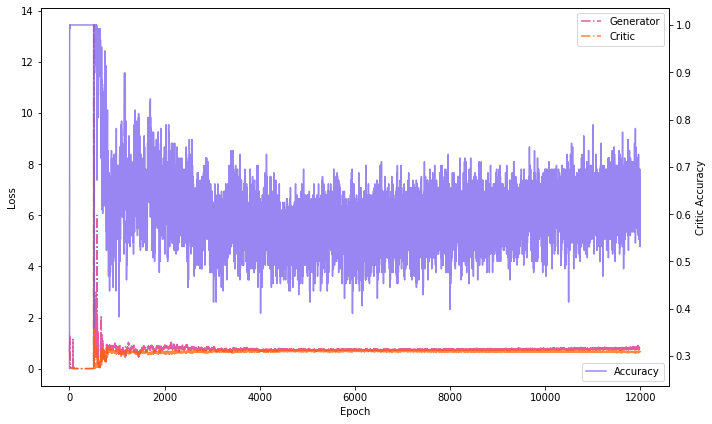

In [8]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(epochs), gloss, '-.', color='#dc267f', alpha = 0.75, label='Generator')
ax1.plot(range(epochs), closs, '-.', color='#fe6100', alpha = 0.75, label='Critic')
ax1.legend(loc=1)
ax2 = ax1.twinx()

ax2.set_ylabel('Critic Accuracy')
ax2.plot(range(epochs), cacc, color='#785ef0', alpha = 0.75, label='Accuracy')
ax2.legend(loc=4)

fig.tight_layout()
plt.show()